In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4

import PyCO2SYS as pyco2

from erddapy import ERDDAP
from erddapy.doc_helpers import show_iframe

import cartopy
cartopy.config['data_dir'] = './maps'
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as feat

In [ ]:
# Subset arguments
datasources = ['SOCAT']#, 'GLODAP'] #EMODNet #
variables = ['FCO2']#PHPH #P09 VOCAB

subset = True
minlat=-90
maxlat=90
minlon=-180
maxlon=180
mindate='1986-06-28T00:00:00Z'
maxdate='1989-06-28T00:00:00Z'


vardict ={'id':'ID', 'doi':'Source_DOI','datevec':'DATEVECTOR','unixd':'UNIXDATE',
          'lat':'LATITUDE','lon':'LONGITUDE','dep':'DEPTH',
          'temp':'TEMPERATURE','sal':'SALINITY','salf':'SALINITY_FLAG',
          'dic' : 'DIC', 'dicf':'DIC_FLAG', 'dicc':'DIC_CALCULATION',
          'alk': 'ALKALINITY', 'alkf':'ALKALINTY_FLAG', 'alkc':'ALKALINITY_CALCULATION',
          'ph': 'pH_TS','phf': 'pH_FLAG','phc': 'pH_CALCULATION',
          'fco2w':'FCO2_W','fco2wf':'FCO2W_FLAG','fco2wc': 'FCO2_CALCULATION','fco2wac':'ACCURACY_FCO2',}

vardictCF={}


outputvars=[
     vardict['id'], vardict['doi'], 'SOURCE',
     vardict['datevec'], vardict['unixd'], vardict['lat'], vardict['lon'],
     vardict['dep'], vardict['temp'], vardict['sal'], vardict['salf'],
     vardict['fco2w'], vardict['fco2wf'], vardict['fco2wc'], vardict['fco2wac'],
     vardict['dic'], vardict['dicf'], vardict['dicc'],
     vardict['alk'], vardict['alkf'], vardict['alkc'],
     vardict['ph'], vardict['phf'], vardict['phc']]

## fCO2 from SOCAT (Time series from Station M, observations from 2015, 2000 vs 2020)

In [ ]:
socatdoi='10.25921/yg69-jd96' # The SOCAT collection DOI info is not in ERDDAP (or can't find it)
flagaccuracy = {"A": 2.0, "B": 2.0, "C": 5.0, "D": 5.0, "E": 10.0}

In [ ]:
e = ERDDAP(
        server='https://data.pmel.noaa.gov/socat/erddap',
        protocol='tabledap',
    )

e.response = 'csv'
e.dataset_id = 'socat_v2021_fulldata' # observations
e.constraints = {
        'platform_name=': "Station M",
        'WOCE_CO2_water=': "2" # only data flagged as "good"
    }
e.variables = ['expocode','time','latitude','longitude','depth','sal','temp',
                   'fCO2_recommended','qc_flag','WOCE_CO2_water','socat_doi']

tempdf = e.to_pandas(dtype={10: str, 8: str, 0: str})

    # Retain only valid fco2 values (can't figure out how to do it in erdappy constrains yet)
tempdf=tempdf.dropna(subset=['fCO2_recommended (uatm)']).copy()
tempdf.reset_index(drop=True, inplace=True)

    # Rename columns
tempdf.rename(
        columns={'expocode': vardict['id'], 'socat_doi':vardict['doi'],
                 'latitude (degrees_north)': vardict['lat'], 'longitude (degrees_east)': vardict['lon'],
                 'depth (m)': vardict['dep'], 'temp (degrees C)': vardict['temp'], 'sal (PSU)': vardict['sal'],
                 'fCO2_recommended (uatm)': vardict['fco2w'], 'WOCE_CO2_water': vardict['fco2wf'],
                 'qc_flag':'Cruise_flag'},
        inplace=True)

commonvars = [i for i in outputvars if i in tempdf.columns]
socat_sm = tempdf.copy()
socat_sm['DATEVECTOR1'] = pd.to_datetime(socat_sm['time (UTC)'])

    # Create python date object
#tempdf['DATEVECTOR1'] = pd.to_datetime(tempdf['time (UTC)'])
#tempdf[vardict['unixd']] = tempdf['DATEVECTOR1'].astype('int64') // 10 ** 9
#tempdf[vardict['datevec']] = tempdf['DATEVECTOR1'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.axes()
socat_sm.plot(x='DATEVECTOR1', y=vardict['fco2w'],ax=ax, 
                linestyle='None', marker='o',grid='on', legend=True)
plt.show()




In [ ]:
# SOCAT grid


In [ ]:
e.constraints = {
        'time>=': mindate,
        'time<=': maxdate,
        'latitude>=': minlat,
        'latitude<=': maxlat,
        'longitude>=': minlon,
        'longitude<=': maxlon,
        'WOCE_CO2_water=': "2" # only data flagged as "good"
    }

tempdf = e.to_pandas(dtype={10: str, 8: str, 0: str})

    # Retain only valid fco2 values (can't figure out how to do it in erdappy constrains yet)
tempdf=tempdf.dropna(subset=['fCO2_recommended (uatm)']).copy()
tempdf.reset_index(drop=True, inplace=True)

    # Rename columns
tempdf.rename(
        columns={'expocode': vardict['id'], 'socat_doi':vardict['doi'],
                 'latitude (degrees_north)': vardict['lat'], 'longitude (degrees_east)': vardict['lon'],
                 'depth (m)': vardict['dep'], 'temp (degrees C)': vardict['temp'], 'sal (PSU)': vardict['sal'],
                 'fCO2_recommended (uatm)': vardict['fco2w'], 'WOCE_CO2_water': vardict['fco2wf'],
                 'qc_flag':'Cruise_flag'},
        inplace=True)

commonvars = [i for i in outputvars if i in tempdf.columns]
socat_area = tempdf.copy()
socat_area['DATEVECTOR1'] = pd.to_datetime(socat_area['time (UTC)'])

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.axes()
socat_area.plot(x='DATEVECTOR1', y=vardict['fco2w'],ax=ax, 
                linestyle='None', marker='o',grid='on', legend=True)
plt.show()

In [ ]:
df=socat_area.copy()

proj=ccrs.cartopy.crs.Miller()
plt.figure(dpi=150)
ax = plt.axes(projection=proj)
if ((minlon != -180) & (maxlon != 180) & (minlat !=-90) & (maxlat != 90)) :
    ax.set_extent([minlon-5,maxlon+5, 
                   maxlat+5,minlat-5])
ax.stock_img()
ax.coastlines()
sc=ax.scatter(df[vardict['lon']],df[vardict['lat']],
              c=df[vardict['fco2w']],s=0.2, label= "fCO2 (uatm)",
             transform=ccrs.PlateCarree())
plt.colorbar(sc)
ax.legend()
plt.show()

In [77]:
#import netCDF4
socat_g = ERDDAP(
  server='http://erddap.sochic-h2020.eu/erddap',
  protocol='griddap',
  response="opendap",

)
socat_g.dataset_id = 'SOCATv2020_tracks_gridded_decadal'

df_socatgrid = socat_g.to_pandas()
df_socatgrid



ValueError('Cannot use ncCF with griddap.')

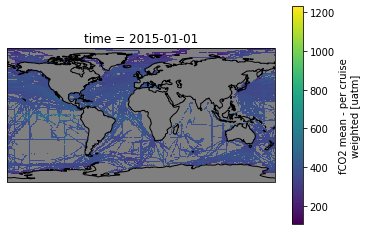

In [76]:

fco2plot=df_socatgrid['fco2_ave_weighted_decade']
p = fco2plot.isel(time=4).plot(
   subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
   transform=ccrs.PlateCarree(),
  )
p.axes.set_global()
p.axes.coastlines()


## GLODAP observations surface fCO2 and gridded

In [ ]:
filespathremote = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0237935/' #only applicable to GLODAP for now


In [ ]:
starttime=time.time()
# Find column header line number
for ds in datasources:

    if ('SOCAT' in ds):
        source='SOCATv2021'
        %run ./BlueCloud_importSOCAT.ipynb

    elif ('GLODAP' in ds):
        source='GLODAPv2.2021'
        exec(open("importGLODAP.py").read())

#    if 'df' not in globals():
#        df = printdf
#    else:
#        df = df.append(printdf)


In [ ]:
# Change format to integer for flags
#allflags=[vardict['salf']]
#df[vardict['salf']] = df[vardict['salf']].astype('UInt8')
#df[vardict['dicf']] = df[vardict['dicf']].astype('UInt8')
#df[vardict['alkf']] = df[vardict['alkf']].astype('UInt8')
#df[vardict['phf']] = df[vardict['phf']].astype('UInt8')
df[vardict['fco2wf']] = df[vardict['fco2wf']].astype('UInt8')
#df[vardict['fco2wc']] = df[vardict['fco2wc']].astype('UInt8')

# Keep only wanted columns

commonvars = [i for i in outputvars if i in df.columns]
df = df[commonvars].copy()


In [ ]:
plt.figure(figsize=(12,6))
ax = plt.axes()
printdf.plot(x='DATEVECTOR1', y=vardict['fco2w'],ax=ax, 
                linestyle='None', marker='o',grid='on', legend=True)
plt.show()

In [ ]:
printdf.DATEVECTOR1.astype

In [ ]:
proj=ccrs.cartopy.crs.Miller()
plt.figure(dpi=150)
ax = plt.axes(projection=proj)
if ((minlon != -180) & (maxlon != 180) & (minlat !=-90) & (maxlat != 90)) :
    ax.set_extent([minlon-5,maxlon+5, 
                   maxlat+5,minlat-5])
ax.stock_img()
ax.coastlines()
sc=ax.scatter(df[vardict['lon']],df[vardict['lat']],
              c=df[vardict['fco2w']],s=0.2, label= "fCO2 (uatm)",
             transform=ccrs.PlateCarree())
plt.colorbar(sc)
ax.legend()
plt.show()